<a href="https://colab.research.google.com/github/Wnjoki/yuYpOTrvBrzkHSgq-MonReader/blob/main/MonReader1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification Using Pytorch

Import libraries

In [1]:

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Define relevant variables for the ML task
batch_size = 32
num_classes = 2
learning_rate = 0.001
num_epochs = 20

In [17]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**Load the Data**

The data to train our model has images and labels attached to it.
It is stored into training and testing folders that consist of images labelled as flip and not flip.



In [4]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#train and test data directory
train_data_dir = "/content/drive/MyDrive/Colab Notebooks/images/training"
test_data_dir = "/content/drive/MyDrive/Colab Notebooks/images/testing"


In [6]:

#load the train and test data
transforms = transforms.Compose([transforms.Resize((28,28)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
train_dataset = ImageFolder(train_data_dir,transform=transforms)
test_dataset = ImageFolder(test_data_dir,transform=transforms)

img, label = train_dataset[0]
print(img.shape,label)

torch.Size([3, 28, 28]) 0


In [7]:
#load the train and test into batches.
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = True)

In the cell above, torchvision.transforms module preprocess the images,  first  resize the image for (28*28) shape and then transforms them into tensors.

The first image in the train_dataset has a shape (3, 28, 28) which means the image has 3 channels (RGB), height 28, and width 28. The image has a label 0, which represents the “flip” class

**Exploring Images :**

To visualize images of a single batch, use make_grid() from torchvision utilities. It gives an overall view of images in batch in the form of an image grid.

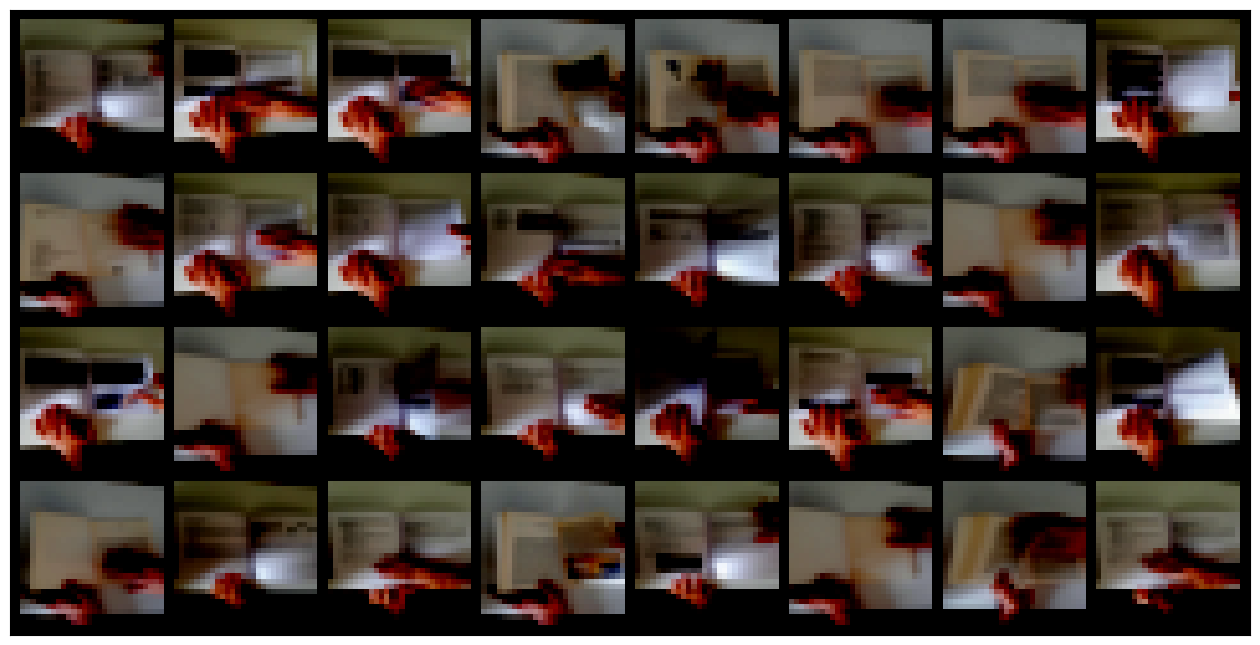

In [8]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

show_batch(train_loader)


Label : flip


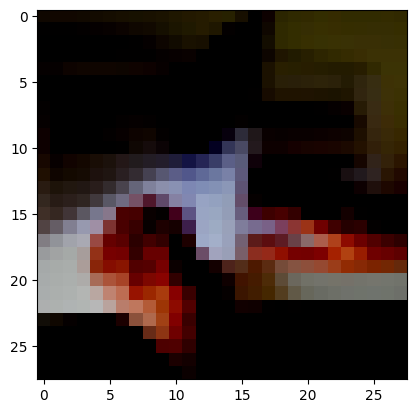

In [9]:
def display_img(img,label):
    print(f"Label : {test_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*test_dataset[0])

The first images in both the train and test datasets are of flip class

**Architecture of the network**

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(p=0.3))


        self.fc1 = nn.Linear(4 * 4 * 128, 625, bias=True)
        nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout(p=0.3))

        self.fc2 = nn.Linear(625, num_classes, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


#Setting Hyperparameters

In [18]:
# instantiate CNN model
model = ConvNet()
model.to(device)

<ipython-input-10-8329ed0c3086>:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc1.weight)


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=2, bias=Tr

In [12]:
#cost function and the algorithm for optimization
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
total_step = len(train_loader)

Hyperparameters


We start by initializing our model with the number of classes. We then choose cross-entropy and Adam as our loss function and optimizer respectively.  We also define the variable total_step to make iteration through various batches easier.

Display of network parameters for each layer


*   Weight
Bias

*   Bias






In [13]:
#Display of network parameters for each layer
for param in model.parameters():
    print(param.size())

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([625, 2048])
torch.Size([625])
torch.Size([2, 625])
torch.Size([2])


#**Model Training**

In [19]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))





Epoch [1/20], Loss: 0.7003
Epoch [2/20], Loss: 0.7180
Epoch [3/20], Loss: 0.7301
Epoch [4/20], Loss: 0.6924
Epoch [5/20], Loss: 0.6888
Epoch [6/20], Loss: 0.7268
Epoch [7/20], Loss: 0.7332
Epoch [8/20], Loss: 0.7496
Epoch [9/20], Loss: 0.6538
Epoch [10/20], Loss: 0.7329
Epoch [11/20], Loss: 0.6562
Epoch [12/20], Loss: 0.7026
Epoch [13/20], Loss: 0.6902
Epoch [14/20], Loss: 0.7066
Epoch [15/20], Loss: 0.7122
Epoch [16/20], Loss: 0.7566
Epoch [17/20], Loss: 0.6907
Epoch [18/20], Loss: 0.7019
Epoch [19/20], Loss: 0.7128
Epoch [20/20], Loss: 0.7620


In [20]:
PATH = './convnet.pth'
torch.save(model.state_dict(), PATH)

#Testing the Model

In [21]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(597, 100 * correct / total))




KeyboardInterrupt: ignored

In [22]:
with torch.no_grad(): # very important
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()



print('Accuracy of the network on the test images: {} %'.format(100 * n_correct / n_samples))

Accuracy of the network on the test images: 49.74874371859296 %


In [23]:
classes = ('flip', 'not flip')

for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

IndexError: ignored